# Author: Akula Venkata Satya Sai Gopinadh

# Reg No: 22228

## Date: 24-07-2023
#### $$ Topic:  AUTOMATIC DIFFERENTIATION WITH TORCH.AUTOGRAD $$


* Back Propagation is the most frequently used algorithm in training the Neural Networks.

* In Back Propagation has the parameters (model weights) are adjusted according to the *"gradient"* of the loss function w.r.t to the given parameter.

* *"torch.autograd"* is an inbuilt differentiation engine in PyTorch used to compute the gradients. This also supports the automatic computation of gradient for any computaional graph.

In [1]:
import torch

In [2]:
x = torch.ones(5)
x

tensor([1., 1., 1., 1., 1.])

In [3]:
y = torch.zeros(3)
y

tensor([0., 0., 0.])

In [4]:
w = torch.randn(5,3, requires_grad=True)
w

tensor([[ 1.0608,  0.7298,  0.4350],
        [ 1.2540,  0.8134, -0.0866],
        [ 2.0024,  0.6946, -0.5081],
        [ 1.2296, -2.0610,  0.3715],
        [-0.0478, -1.6524,  0.5759]], requires_grad=True)

In [5]:
b = torch.randn(3, requires_grad=True)
b

tensor([-0.7699,  0.4597,  2.2447], requires_grad=True)

In [6]:
z = torch.matmul(x,w)+ b
z

tensor([ 4.7292, -1.0159,  3.0323], grad_fn=<AddBackward0>)

* Consider the simplest one-layer neural network, with input x, parameters w and b, and some loss function. It can be defined in PyTorch in the following manner:

In [7]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)


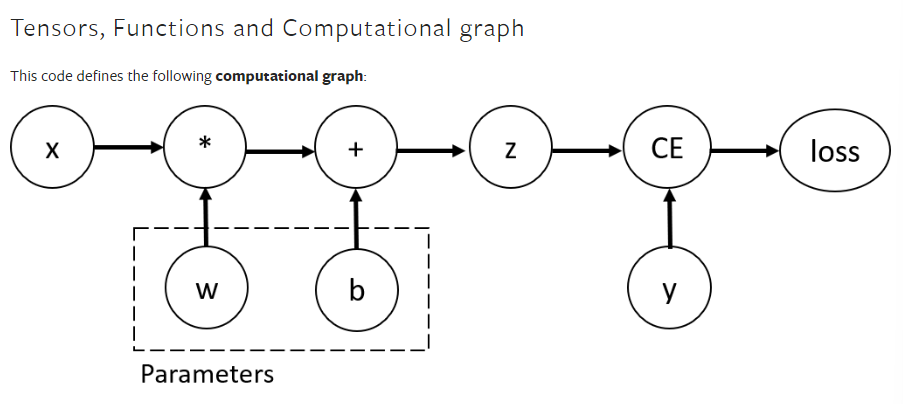

* In this network, w and b are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. In order to do that, we set the requires_grad property of those tensors

$ NOTE: $
* You can set the value of requires_grad when creating a tensor, or later by using x.requires_grad_(True) method.

* A function that we apply to tensors to construct computational graph is in fact an object of class Function.

* This object knows how to compute the function in the forward direction, and also how to compute its derivative during the backward propagation step.

* A reference to the backward propagation function is stored in grad_fn property of a tensor.

In [8]:
print(f"Gradient function for z = {z.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x000001B23F889390>


In [9]:
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x000001B23F888550>


### Computing Gradients

* To optimize weights of parameters in the neural network, we need to compute the derivatives of our loss function with respect to parameters, namely, we need 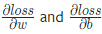under some fixed values of x and y.

* To compute those derivatives, we call loss.backward(), and then retrieve the values from w.grad and b.grad: 



In [10]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2045, 0.1843, 0.0335],
        [0.2045, 0.1843, 0.0335],
        [0.2045, 0.1843, 0.0335],
        [0.2045, 0.1843, 0.0335],
        [0.2045, 0.1843, 0.0335]])
tensor([0.2045, 0.1843, 0.0335])


* We can only obtain the gradients of the leaf nodes of the computational graph, which have *requires_grad* property set to True.
* For all the other nodes of the graph, the gradients will not be available.

* We can only perform gradient calculations using *backward* once on a given graph, for performance reasons. If we need to do several backward calls on the same graph, we need to pass *retain_graph = True* to the backward call.

### Disabling Gradient Tracking

* By default, all tensors with requires_grad=True are tracking their computational history and support gradient computation. 
* However, there are some cases when we do not need to do that, for example, when we have trained the model and just want to apply it to some input data, i.e. we only want to do forward computations through the network. 
* We can stop tracking computations by surrounding our computation code with torch.no_grad() block:

In [11]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

True


In [12]:
with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

False


* Another way to achieve the same result is to use the detach() method on the tensor:

In [13]:
z =torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


---> There are reasons you might want to disable gradient tracking:
* To mark some parameters in your neural network as *frozen parameters*.

* To "speed up computations" when you are only doing forward pass, because computations on tensors that do not track gradients would be more efficient.

#### More on Computational Graphs
* Conceptually, autograd keeps a record of data (tensors) and all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG) consisting of Function objects. In this DAG, leaves are the input tensors, roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

-->In a forward pass, autograd does two things simultaneously:

    * run the requested operation to compute a resulting tensor

    * maintain the operation’s gradient function in the DAG.

--> The backward pass kicks off when .backward() is called on the DAG root. autograd then:

    * computes the gradients from each .grad_fn,

    * accumulates them in the respective tensor’s .grad attribute

    * using the chain rule, propagates all the way to the leaf tensors.


### NOTE: 
    * DAGs are dynamic in PyTorch An important thing to note is that the graph is recreated from scratch; after each .backward() call; autograd starts populating a new graph.
    * This is exactly what allows us to control flow statements in the model.
    * We can also change the shape, size and operations at every iteration if needed.

In [14]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])
